# Step 4: Feature Importance:
In this notebook, we assess the importance of different features using the American Community Survey (ACS) estimate data as features and the overall childhood opportunity index as the target. We identify 56 of 119 features that are more than 80% correlated and remove those features from the dataset.

In [21]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import io, s3fs, json, traceback
pd.set_option('display.max_columns', None)
print('Program run at', dt.now())

Program run at 2021-06-15 18:53:29.566016


In [22]:
#read in the estimate data with the overall COI as the target
est = pd.read_csv('s3://bleeding-hearts/workingdata/est_overall.csv')
est.drop(columns=['Unnamed: 0'],inplace=True)
est.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Columns: 120 entries, EMPLOYMENT STATUS_Population 16 years and over to Child Opportunity Levels, overall COI, nationally-normed
dtypes: float64(118), int64(1), object(1)
memory usage: 16.7+ MB


In [23]:
#impute mean values for missing values
means = {}
cols=list(est)
for c in cols:
    if len(est) - est[c].count() > 0:
        means[c] = est[c].dropna().mean()
est.fillna(value=means,inplace=True)
#check that there are no more missing values
est.columns[est.isnull().any()]

Index([], dtype='object')

In [24]:
#make label lists
cat_labels = list(set(est['Child Opportunity Levels, overall COI, nationally-normed']))

In [25]:
from pandas import plotting
import matplotlib.pyplot as plt

# Ignore warnings from scikit-learn to make this notebook a bit nicer
import warnings
warnings.simplefilter('ignore')

# Models may be implemented as pipelines
from sklearn.pipeline import Pipeline

# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
#Pipeline toolset
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

#Model toolset
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

#from yellowbrick.datasets import load_game
from yellowbrick.target import ClassBalance
from sklearn.utils import resample

from sklearn.model_selection import train_test_split as tts
from sklearn.impute import SimpleImputer

## Feature importance - all ACS features
First we ran feature importance for all the ACS features.

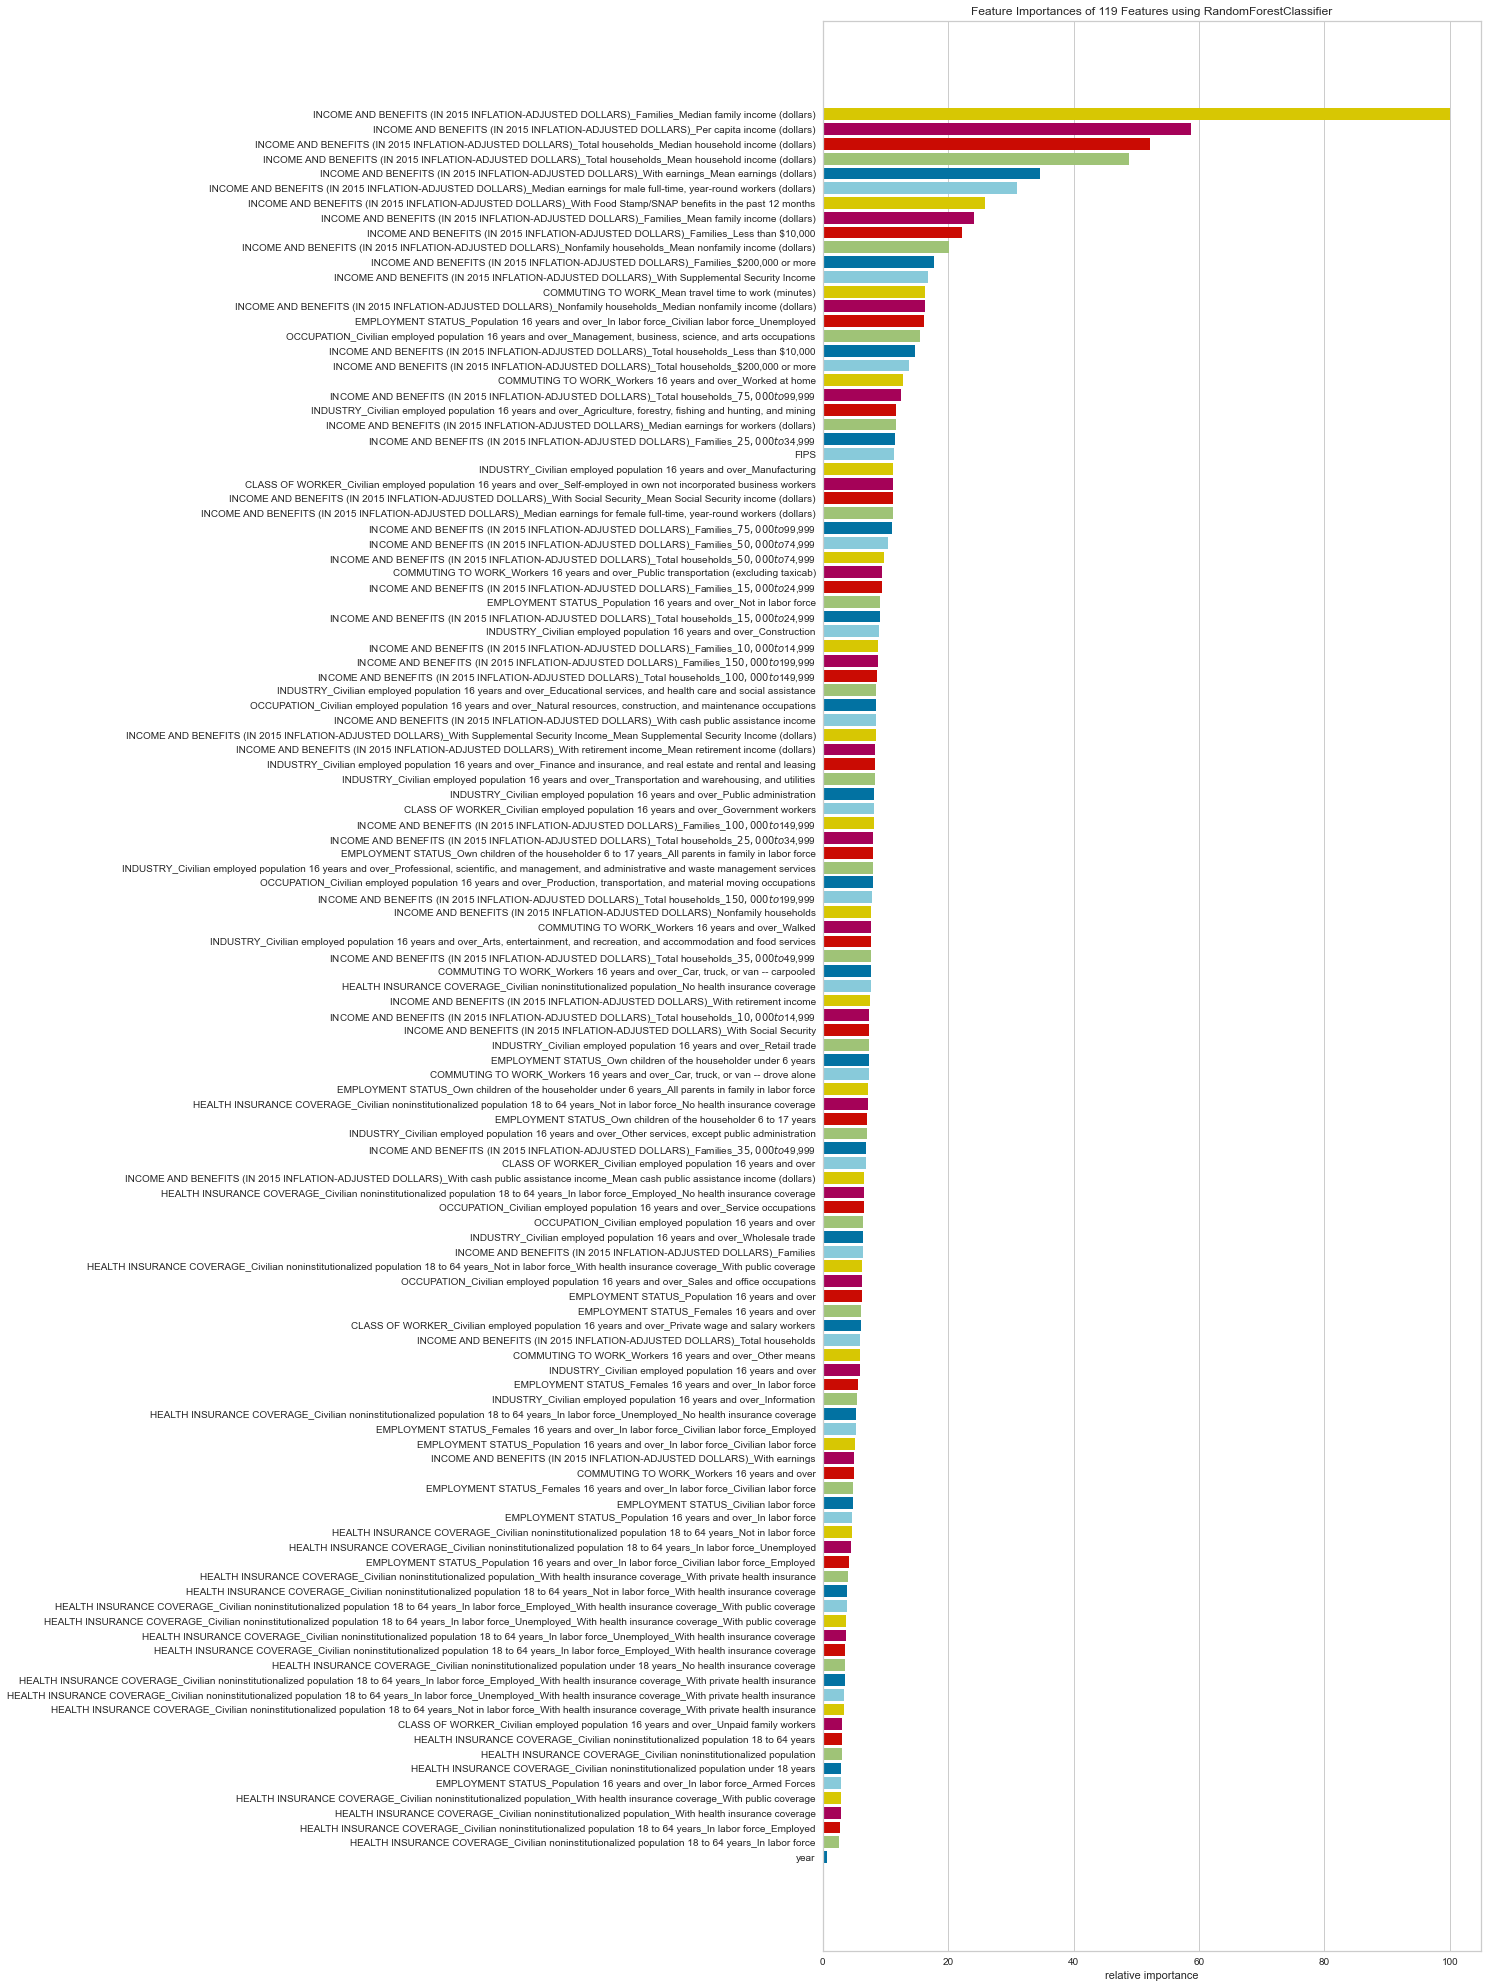

<AxesSubplot:title={'center':'Feature Importances of 119 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [30]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances

# Load the classification data set
X = est.loc[:, est.columns != 'Child Opportunity Levels, overall COI, nationally-normed']
y = est['Child Opportunity Levels, overall COI, nationally-normed']

model = RandomForestClassifier(n_estimators=12)
viz = FeatureImportances(model,size=(1500, 2000))
viz.fit(X, y)
viz.show()

## Identify features that are more than 80% correlated
Next, we use the pandas .corr function to identify features that are more than 80% correlated and remove them from the dataset.

In [32]:
corrdf = est.corr()
feats = corrdf.index.to_list()
featscol= corrdf.columns.to_list()
pd.options.display.max_colwidth = 300
newdf = pd.DataFrame(columns=['Feature 1','Feature 2','Value'])
i = 0
for f in feats:
    for c in featscol:
        if f == c: 
            pass
        elif corrdf.loc[f][c] >= 0.8:
            newdf.loc[i] = [f, c, corrdf.loc[f][c]]
            i+=1
newdf.sort_values(['Feature 1', 'Feature 2'], ascending=[True, True],inplace=True)
#delete duplicate values because they are repeated combinations
newdf.drop_duplicates(subset='Value',inplace=True)
newdf

,Feature 1,Feature 2,Value
428,CLASS OF WORKER_Civilian employed population 16 years and over,CLASS OF WORKER_Civilian employed population 16 years and over_Private wage and salary workers,0.985226
420,CLASS OF WORKER_Civilian employed population 16 years and over,COMMUTING TO WORK_Workers 16 years and over,0.994800
421,CLASS OF WORKER_Civilian employed population 16 years and over,"COMMUTING TO WORK_Workers 16 years and over_Car, truck, or van -- drove alone",0.980483
413,CLASS OF WORKER_Civilian employed population 16 years and over,EMPLOYMENT STATUS_Civilian labor force,0.995530
414,CLASS OF WORKER_Civilian employed population 16 years and over,EMPLOYMENT STATUS_Females 16 years and over,0.918616
...,...,...,...
529,INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With earnings,"OCCUPATION_Civilian employed population 16 years and over_Management, business, science, and arts occupations",0.815735
530,INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With earnings,OCCUPATION_Civilian employed population 16 years and over_Sales and office occupations,0.894629
378,INDUSTRY_Civilian employed population 16 years and over_Construction,"OCCUPATION_Civilian employed population 16 years and over_Natural resources, construction, and maintenance occupations",0.861909
393,"INDUSTRY_Civilian employed population 16 years and over_Professional, scientific, and management, and administrative and waste management services","OCCUPATION_Civilian employed population 16 years and over_Management, business, science, and arts occupations",0.830922


In [35]:
est_rmv = est.drop(columns=list(set(newdf['Feature 2'])))
print('#/columns in est data:',len(est.columns),'\n','#/columns in est_rmv data:',len(est_rmv.columns), '\n','We removed', len(est.columns)-len(est_rmv.columns),'columns that were more than 80% correlated')

#/columns in est data: 120 
 #/columns in est_rmv data: 64 
 We removed 56 columns that were more than 80% correlated


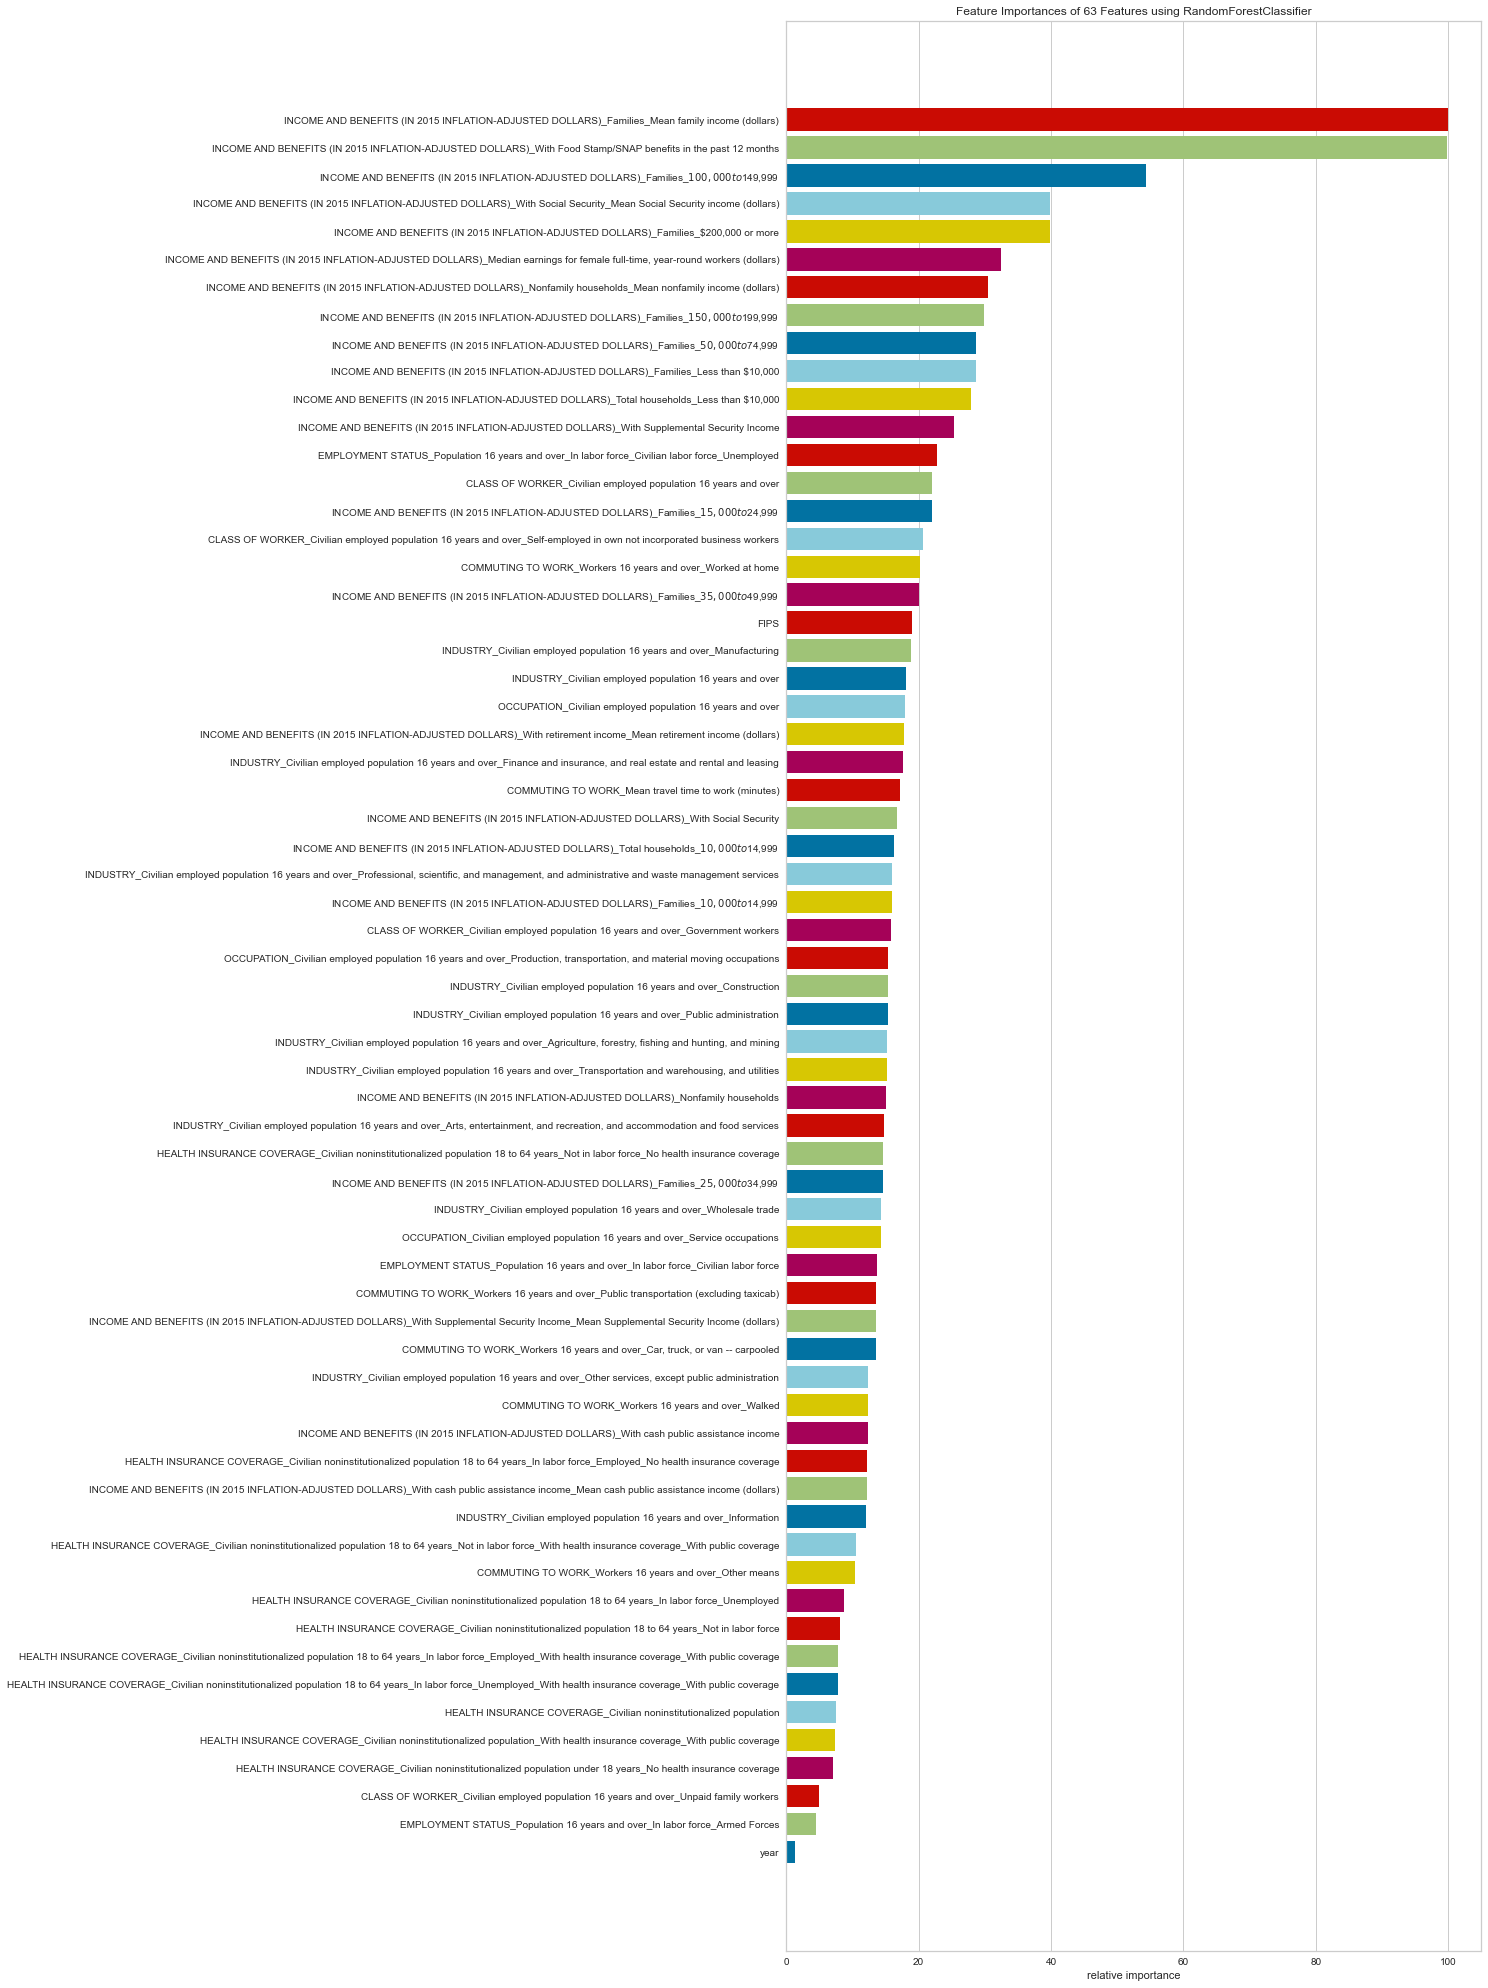

<AxesSubplot:title={'center':'Feature Importances of 63 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [9]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances

# Load the classification data set
X = est_rmv.loc[:, est_rmv.columns != 'Child Opportunity Levels, overall COI, nationally-normed']
y = est_rmv['Child Opportunity Levels, overall COI, nationally-normed']

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model,size=(1500, 2000))
viz.fit(X, y)
viz.show()

In [10]:
#save the dataset without highly correlated features to S3
with open('/Volumes/Key/aws_keys.json') as f:
  creds = json.load(f)

def s3upload(name,df):
    x = df.to_csv(None).encode()
    fs = s3fs.S3FileSystem(key=creds['AWSAccessKeyId'], secret=creds['AWSSecretKey'])
    with fs.open('s3://bleeding-hearts/workingdata/' + name + '.csv', 'wb') as f:
        f.write(x)
    print('saved')

s3upload('est_rmv',est_rmv)

saved


## Run models on 63 features that are less than 80% correlated

In [36]:
from pandas import plotting
import matplotlib.pyplot as plt

# Ignore warnings from scikit-learn to make this notebook a bit nicer
import warnings
warnings.simplefilter('ignore')

# Models may be implemented as pipelines
from sklearn.pipeline import Pipeline

# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
#Pipeline toolset
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

#Model toolset
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

#from yellowbrick.datasets import load_game
from yellowbrick.target import ClassBalance
from sklearn.utils import resample

from sklearn.model_selection import train_test_split as tts
from sklearn.impute import SimpleImputer

In [37]:
def viz_cb(y,lst):
    visualizer = ClassBalance(labels=lst)
    visualizer.fit(y)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

In [38]:
def class_balance(df,target):
    print('Raw Value Counts:','\n',df[target].value_counts())
    X = df.loc[:, df.columns != target]
    y = df[target]
    #make a dataframe of value counts and a list of the values in the target
    df1 = y.value_counts().to_frame('count').reset_index(level=0).rename(columns={'index':'value'})
    label_lst = list(df1['value'])
    
    viz_cb(y,label_lst)

    #identify minimum value number and label name
    mi = df1['count'].min()
    name = df1.loc[df1['count'] == mi,'value'].iloc[0]
    print('min value is',name,'in values',label_lst)

    seed = 123
    # Downsample majority class
    
    #use min value number and label name to resample the dataframe
    df2 = pd.concat([resample(df[df[target]== i],
                            replace=False,
                            n_samples=mi,
                            random_state=seed) for i in label_lst if i != name]).append(df[df[target]== name])
    print('Resampled Value Counts:','\n',df2[target].value_counts())
    X = df2.loc[:, df.columns != target]
    y = df2[target]
    viz_cb(y,label_lst)
    return df2

In [39]:
def train_test(X,y):
    X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

In [40]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)


models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]


def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)
    

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted,average='micro')))

In [41]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visualize_model(X, y, estimator,label_lst, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=label_lst,
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

In [42]:
import matplotlib as plt
from yellowbrick.classifier import confusion_matrix

def conf_matrix(X,y,estimator,label_lst, **kwargs):
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])


    #Create the train and test data
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
    model.fit(X, y)
    # Instantiate the visualizer with the classification model
    confusion_matrix(
        model,
        X_train, y_train, X_test, y_test,
        classes=label_lst
    )
    plt.tight_layout()
    plt.show()

## No Class Balance

(14566, 63) (14566,)
(3642, 63) (3642,)
F1 SCORE SVC: 0.8092596660808437


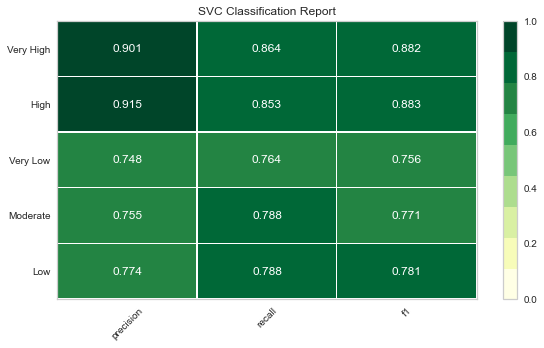

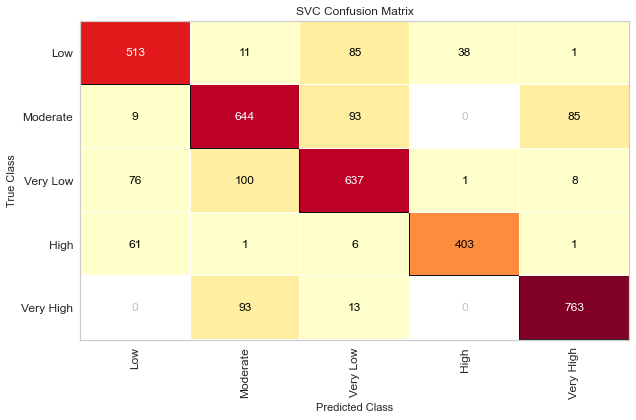

SVC(gamma='auto') Traceback (most recent call last):
  File "<ipython-input-18-444b68a0154d>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE NuSVC: 0.749615553602812


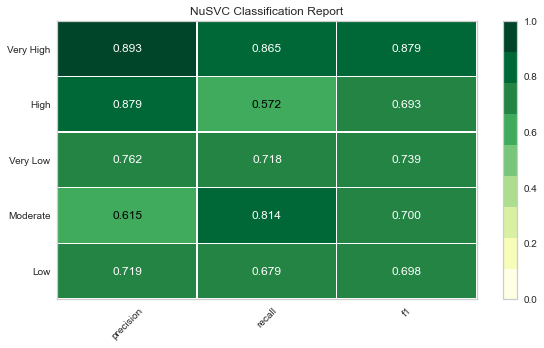

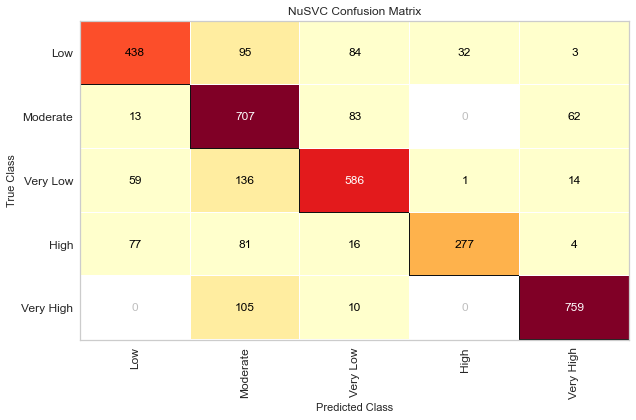

NuSVC(gamma='auto') Traceback (most recent call last):
  File "<ipython-input-18-444b68a0154d>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LinearSVC: 0.6206063268892794


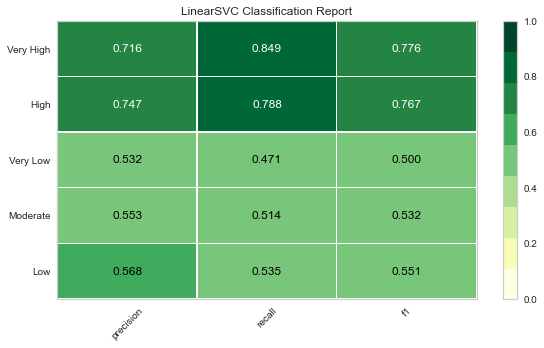

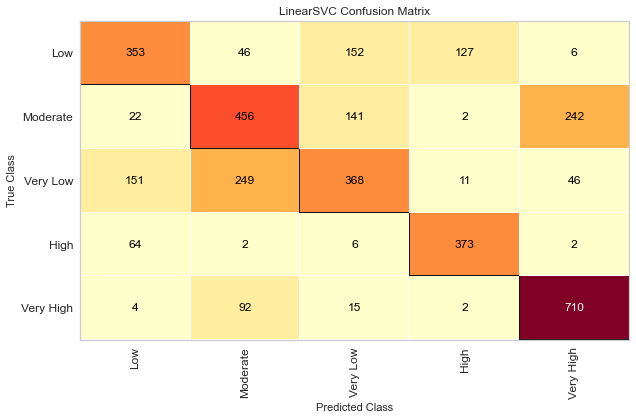

LinearSVC() Traceback (most recent call last):
  File "<ipython-input-18-444b68a0154d>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE SGDClassifier: 0.5193321616871704


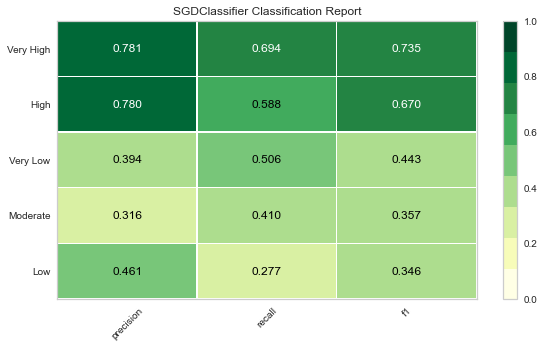

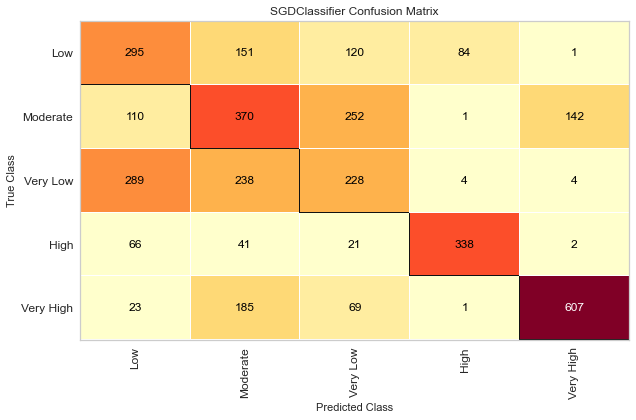

SGDClassifier(max_iter=100) Traceback (most recent call last):
  File "<ipython-input-18-444b68a0154d>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE KNeighborsClassifier: 0.6920584358523726


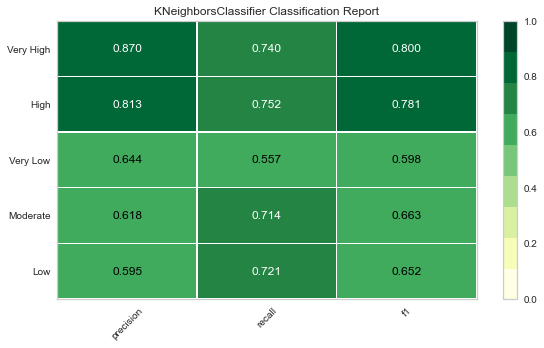

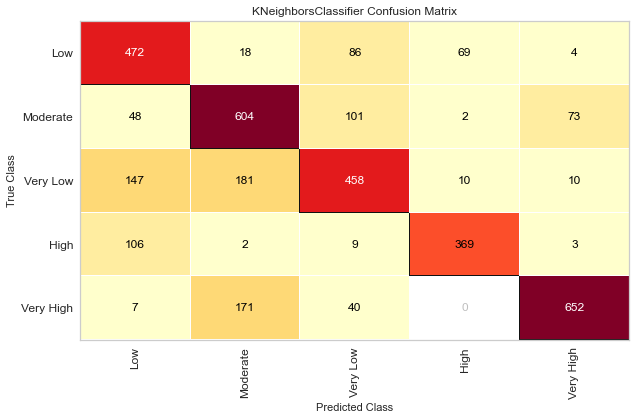

KNeighborsClassifier() Traceback (most recent call last):
  File "<ipython-input-18-444b68a0154d>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LogisticRegression: 0.6286247803163445


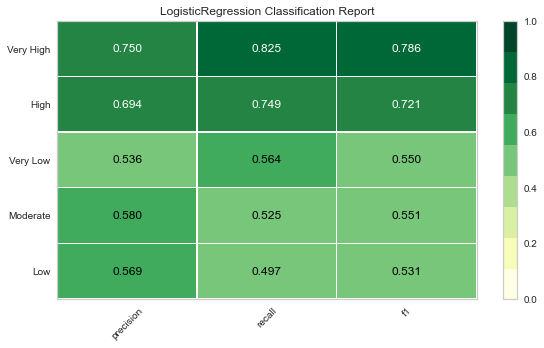

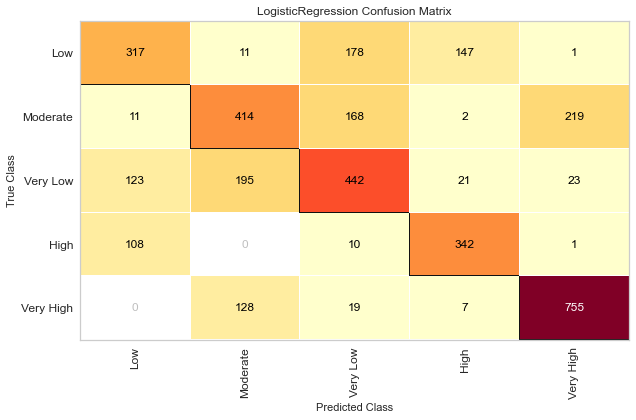

LogisticRegression() Traceback (most recent call last):
  File "<ipython-input-18-444b68a0154d>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LogisticRegressionCV: 0.6701449912126538


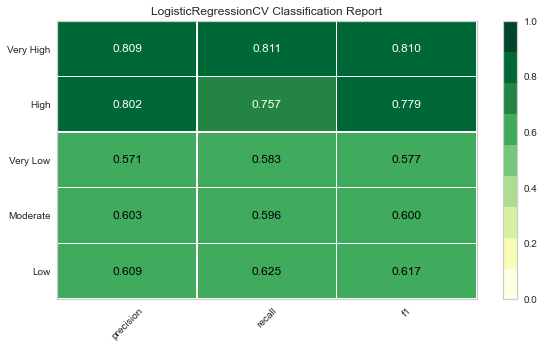

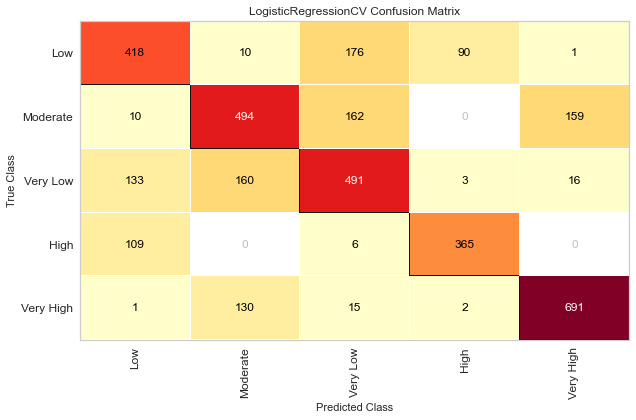

LogisticRegressionCV(cv=3) Traceback (most recent call last):
  File "<ipython-input-18-444b68a0154d>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE BaggingClassifier: 0.9887961335676626


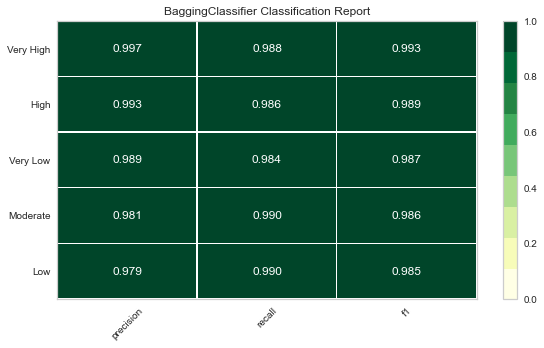

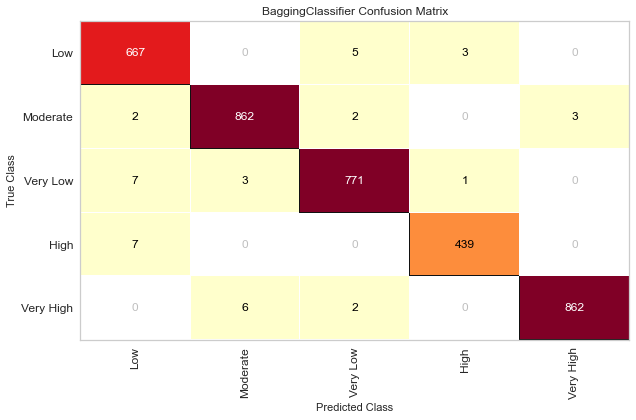

BaggingClassifier() Traceback (most recent call last):
  File "<ipython-input-18-444b68a0154d>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE ExtraTreesClassifier: 1.0


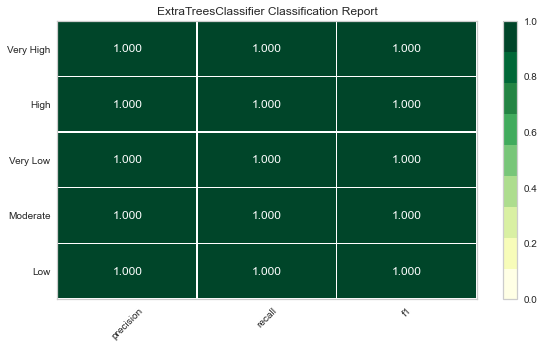

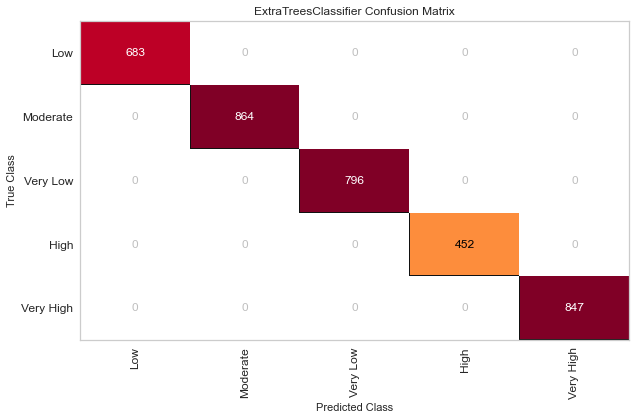

ExtraTreesClassifier(n_estimators=300) Traceback (most recent call last):
  File "<ipython-input-18-444b68a0154d>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE RandomForestClassifier: 1.0


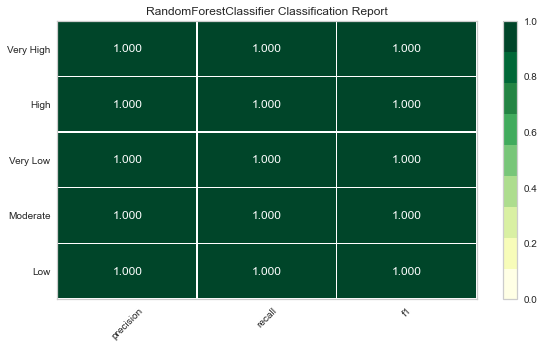

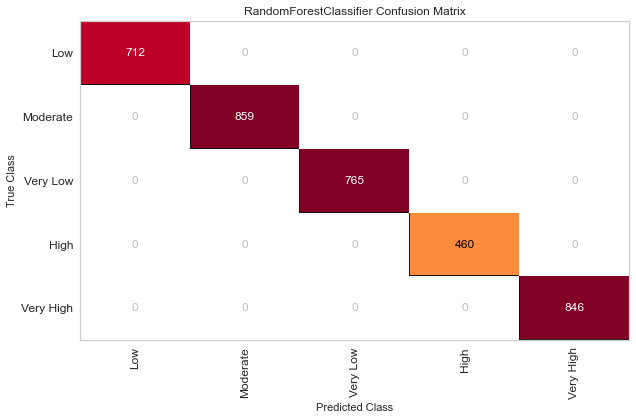

RandomForestClassifier(n_estimators=300) Traceback (most recent call last):
  File "<ipython-input-18-444b68a0154d>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable


In [18]:
X = est_rmv.loc[:, est_rmv.columns != 'Child Opportunity Levels, overall COI, nationally-normed']
y = est_rmv['Child Opportunity Levels, overall COI, nationally-normed']
train_test(X,y)
for model in models:
    try:
        score_model(X, y, model)
        visualize_model(X, y, model,cat_labels)
        conf_matrix(X, y, model,cat_labels)
    except Exception as exc:
        print(model, 
              traceback.format_exc(), 
              exc)

## Class Balance

Raw Value Counts: 
 Very Low     4355
Low          4226
Moderate     3990
High         3328
Very High    2309
Name: Child Opportunity Levels, overall COI, nationally-normed, dtype: int64


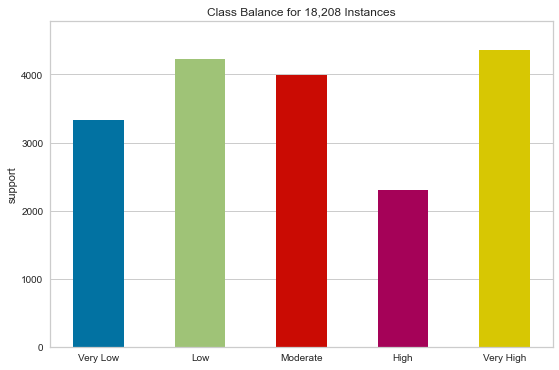

min value is Very High in values ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
Resampled Value Counts: 
 Low          2309
High         2309
Very Low     2309
Very High    2309
Moderate     2309
Name: Child Opportunity Levels, overall COI, nationally-normed, dtype: int64


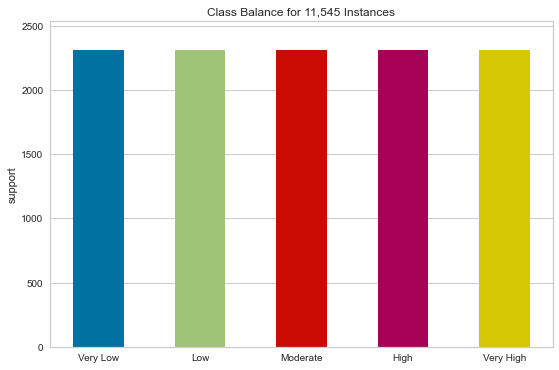

(9236, 63) (9236,)
(2309, 63) (2309,)
F1 SCORE SVC: 0.8103941100043309


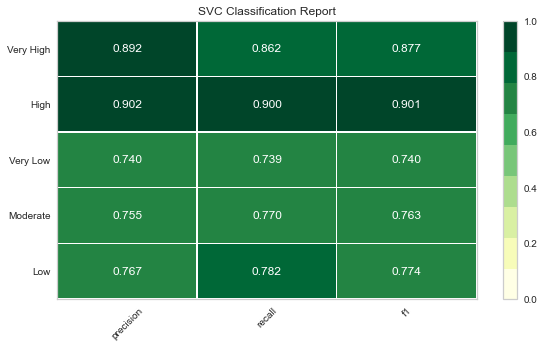

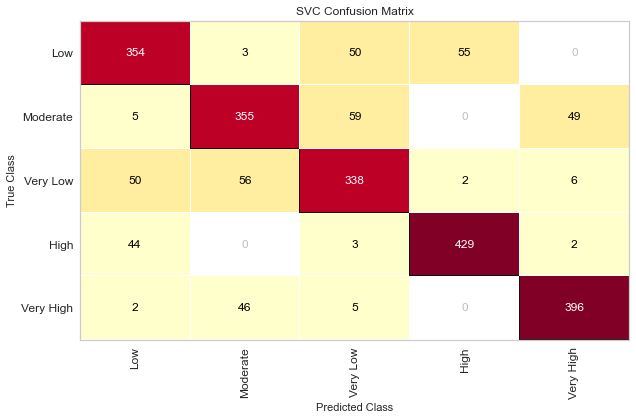

SVC(gamma='auto') Traceback (most recent call last):
  File "<ipython-input-20-68255e51f62a>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE NuSVC: 0.7934170636639238


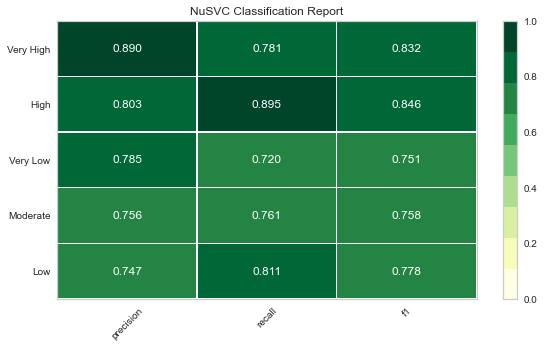

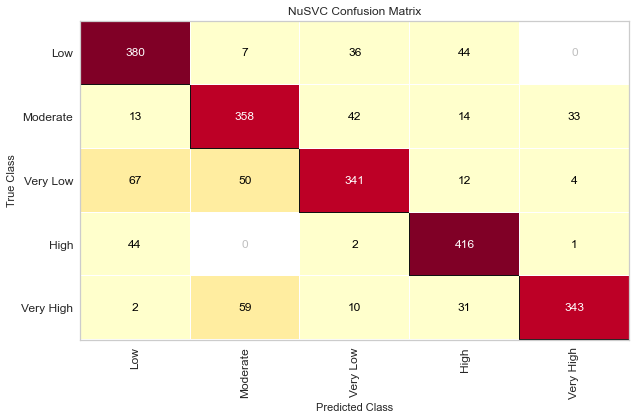

NuSVC(gamma='auto') Traceback (most recent call last):
  File "<ipython-input-20-68255e51f62a>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LinearSVC: 0.6213945430922477


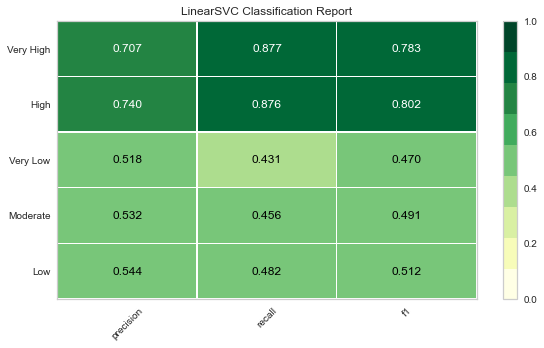

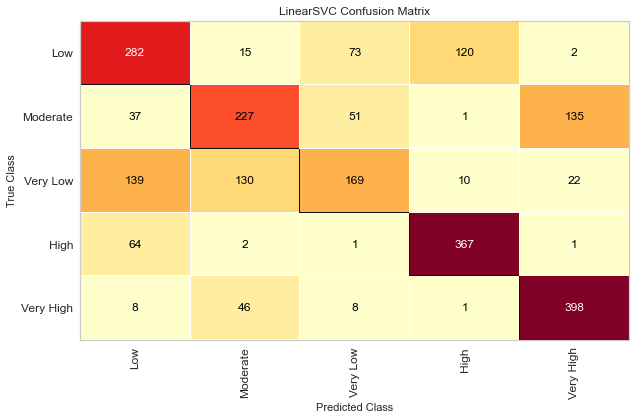

LinearSVC() Traceback (most recent call last):
  File "<ipython-input-20-68255e51f62a>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE SGDClassifier: 0.5077522737115634


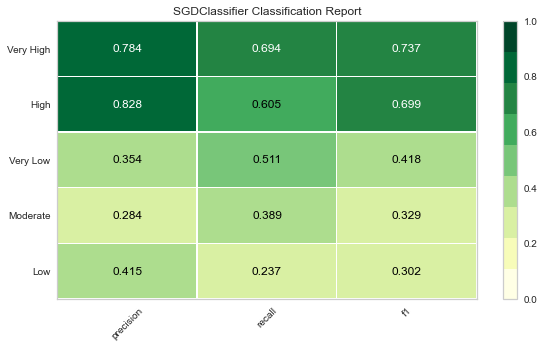

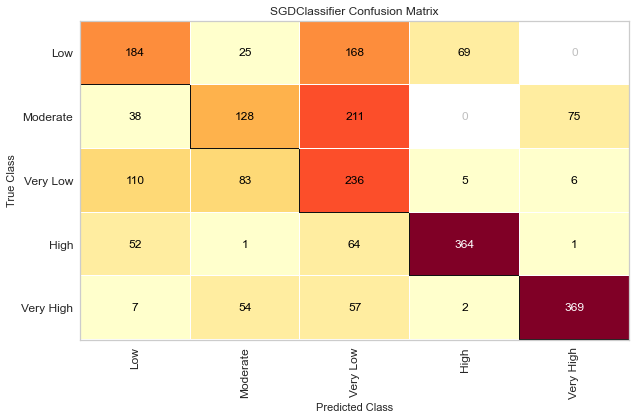

SGDClassifier(max_iter=100) Traceback (most recent call last):
  File "<ipython-input-20-68255e51f62a>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE KNeighborsClassifier: 0.6990905153746211


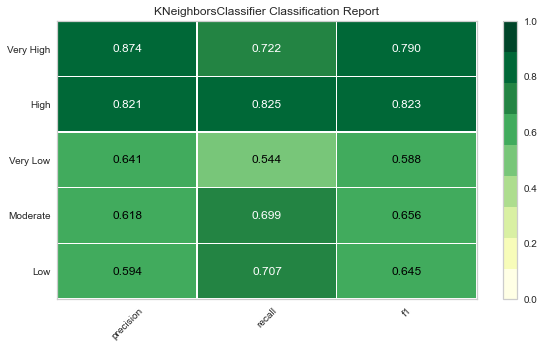

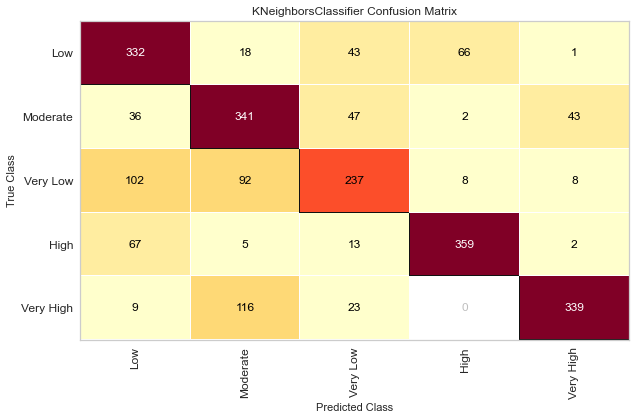

KNeighborsClassifier() Traceback (most recent call last):
  File "<ipython-input-20-68255e51f62a>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LogisticRegression: 0.6426158510177566


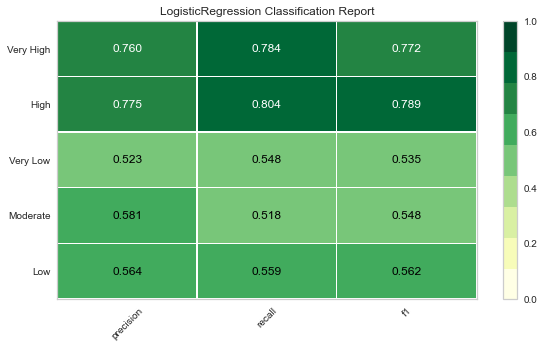

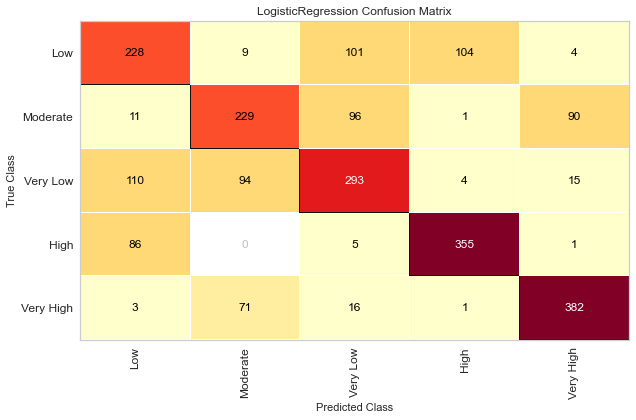

LogisticRegression() Traceback (most recent call last):
  File "<ipython-input-20-68255e51f62a>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LogisticRegressionCV: 0.6834127327847553


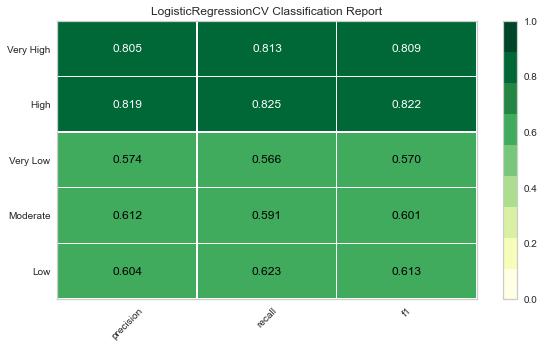

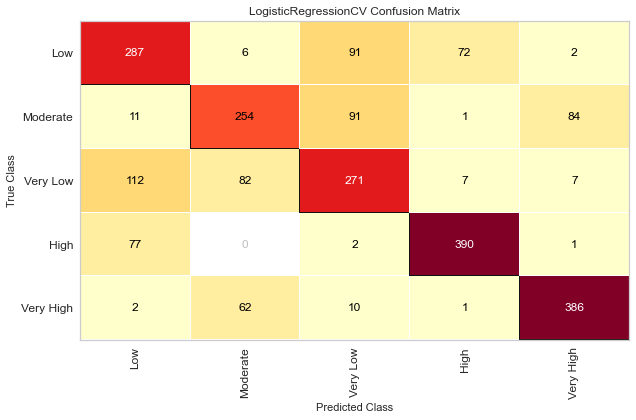

LogisticRegressionCV(cv=3) Traceback (most recent call last):
  File "<ipython-input-20-68255e51f62a>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE BaggingClassifier: 0.9887397141619749


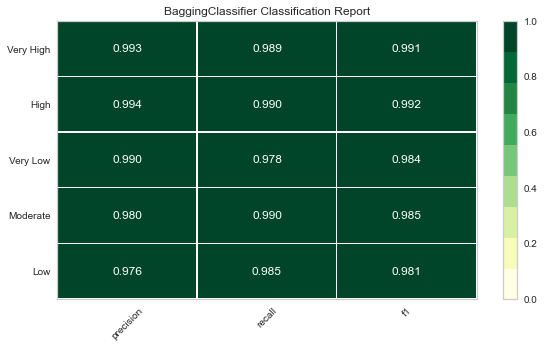

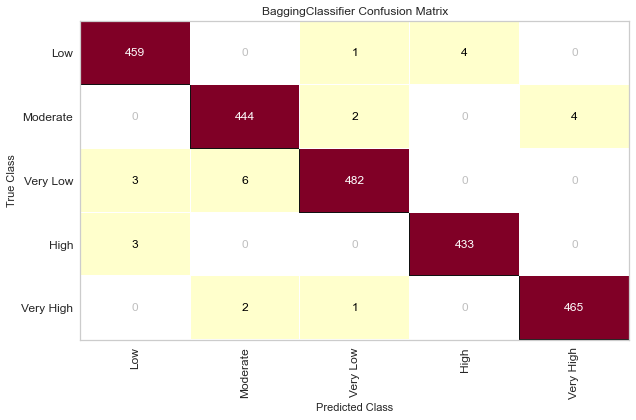

BaggingClassifier() Traceback (most recent call last):
  File "<ipython-input-20-68255e51f62a>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE ExtraTreesClassifier: 1.0


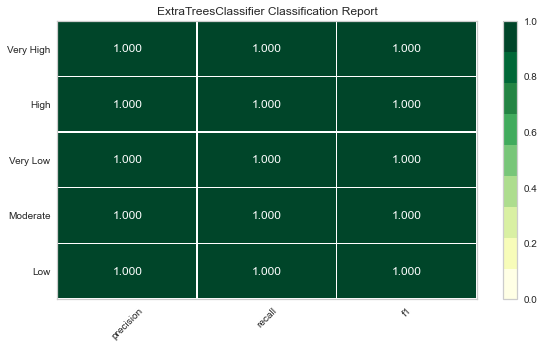

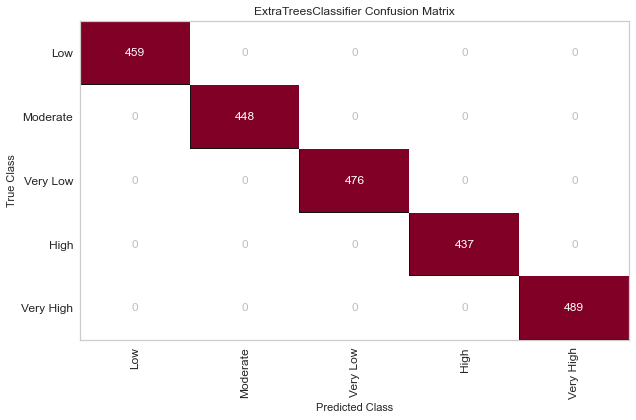

ExtraTreesClassifier(n_estimators=300) Traceback (most recent call last):
  File "<ipython-input-20-68255e51f62a>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE RandomForestClassifier: 1.0


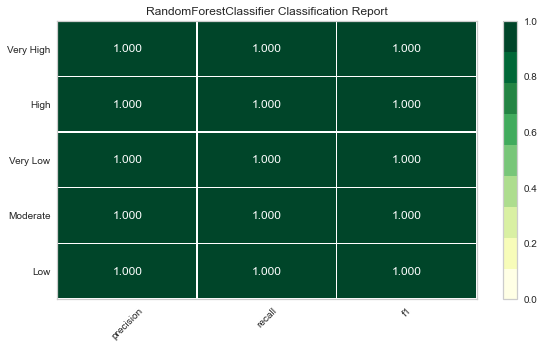

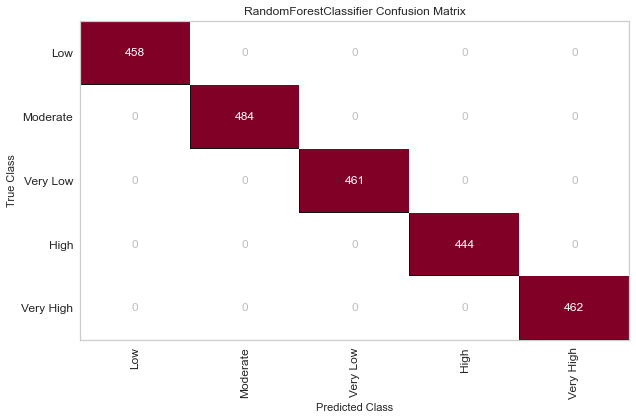

RandomForestClassifier(n_estimators=300) Traceback (most recent call last):
  File "<ipython-input-20-68255e51f62a>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-17-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable


In [20]:
data = class_balance(est_rmv,'Child Opportunity Levels, overall COI, nationally-normed')
X = data.loc[:, data.columns != 'Child Opportunity Levels, overall COI, nationally-normed']
y = data['Child Opportunity Levels, overall COI, nationally-normed']
train_test(X,y)
for model in models:
    try:
        score_model(X, y, model)
        visualize_model(X, y, model, cat_labels)
        conf_matrix(X, y, model,cat_labels)
    except Exception as exc:
        print(model, 
              traceback.format_exc(), 
              exc)